In [21]:
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import datetime
import pandas as pd
from analisis.general.io_helper import getMkdir

OBSV_DATE = datetime.date(year=2022, month=12, day=9).strftime("%Y-%m-%d")

# OBJ_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]
EPOCH_OBSV_KEY = "E_OTIME"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

assert os.path.exists(DATE_DATA_DIR), f"{DATE_DATA_DIR} not found"
DATE_DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09'

In [27]:
# TODO: turn observed times to UTC; currently in local time only

import numpy as np
from scipy import stats
from astropy.io import ascii

PHOTOMETRIC_BASE_KEYS = ["SUM", "AREA", "FLUX", "MAG", "MERR"]
OBSV_KEY = "OTIME"

qphotResultsDir = os.path.join(DATE_DATA_DIR, "qphot-results")
assert os.path.exists(qphotResultsDir), qphotResultsDir

data = ascii.read(os.path.join(qphotResultsDir, "phot"))
pandasData = data.to_pandas()
apertureCols = [c for c in pandasData.columns if c.startswith('RAPERT')]
pandasData[OBSV_KEY] = pd.to_datetime(pandasData[OBSV_KEY])

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
# pandasData[EPOCH_OBSV_KEY] = (pandasData[OBSV_KEY] - pd.Timestamp("1970-01-01")) / pd.Timedelta(hours=1.0)
pandasData[EPOCH_OBSV_KEY] = pd.DatetimeIndex(pandasData[OBSV_KEY]).to_julian_date()

for starId, starName in STAR_IDS.items():
	starData = pandasData[pandasData['LID'] == starId].copy()		
	starResultsDir = getMkdir(os.path.join(qphotResultsDir, starName))
	for rapert in apertureCols:
		apertureId = rapert.replace("RAPERT", "")
		apertureRadius = starData.loc[starData.index[0], f"RAPERT{apertureId}"]
		apertureDir = getMkdir(os.path.join(starResultsDir, f"{rapert} - {apertureRadius}"))
		for basePhotKey in PHOTOMETRIC_BASE_KEYS:
			photKey = f"{basePhotKey}{apertureId}"
			photDf = starData[[EPOCH_OBSV_KEY, photKey]].copy()
			photDf = photDf[~(np.isnan(photDf[photKey]))]
			
			photDf['zscore'] = np.abs(stats.zscore(photDf[photKey]))
			photDf = photDf[(np.abs(stats.zscore(photDf[photKey])) < 2)]

			photDf.to_csv(os.path.join(apertureDir, f"{basePhotKey}.dat"), index=False, sep=' ')

pandasData

,IMAGE,XINIT,YINIT,ID,COORDS,LID,XCENTER,YCENTER,XSHIFT,YSHIFT,...,PERROR6,RAPERT7,SUM7,AREA7,FLUX7,MAG7,MERR7,PIER7,PERROR7,E_OTIME
0,s_bdf_2022-12-09_18-59-,964.50,564.91,1,coords,1,964.330,567.507,-0.170,2.597,...,NoError,20.0,258894.7,1256.579,34378.820,18.105,0.036,0,NoError,2.459923e+06
1,s_bdf_2022-12-09_18-59-,1398.80,756.32,2,coords,2,1399.182,758.796,0.382,2.476,...,NoError,20.0,4981519.0,1256.840,4749624.000,12.754,0.000,0,NoError,2.459923e+06
2,s_bdf_2022-12-09_18-59-,619.44,1010.56,3,coords,3,619.904,1012.796,0.464,2.236,...,NoError,20.0,3053283.0,1256.898,2826237.000,13.317,0.000,0,NoError,2.459923e+06
3,s_bdf_2022-12-09_19-00-,964.50,564.91,4,coords,1,963.671,567.294,-0.829,2.384,...,NoError,20.0,257433.4,1256.761,33824.580,18.122,0.025,0,NoError,2.459923e+06
4,s_bdf_2022-12-09_19-00-,1398.80,756.32,5,coords,2,1398.377,758.496,-0.423,2.176,...,NoError,20.0,4998387.0,1256.524,4765507.000,12.750,0.000,0,NoError,2.459923e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,s_bdf_2022-12-10_01-16-,1398.80,756.32,416,coords,2,1398.132,757.027,-0.668,0.707,...,NoError,20.0,3992239.0,1256.402,993960.600,14.452,0.002,0,NoError,2.459924e+06
416,s_bdf_2022-12-10_01-16-,619.44,1010.56,417,coords,3,623.395,1012.853,3.955,2.293,...,NoError,20.0,3805743.0,1257.161,727999.100,14.790,0.003,0,NoError,2.459924e+06
417,s_bdf_2022-12-10_01-17-,964.50,564.91,418,coords,1,963.186,566.539,-1.314,1.629,...,NoError,20.0,3089202.0,1256.963,5437.525,20.107,0.394,0,NoError,2.459924e+06
418,s_bdf_2022-12-10_01-17-,1398.80,756.32,419,coords,2,1393.584,753.279,-5.216,-3.041,...,NoError,20.0,4042751.0,1256.757,1001977.000,14.443,0.002,0,NoError,2.459924e+06


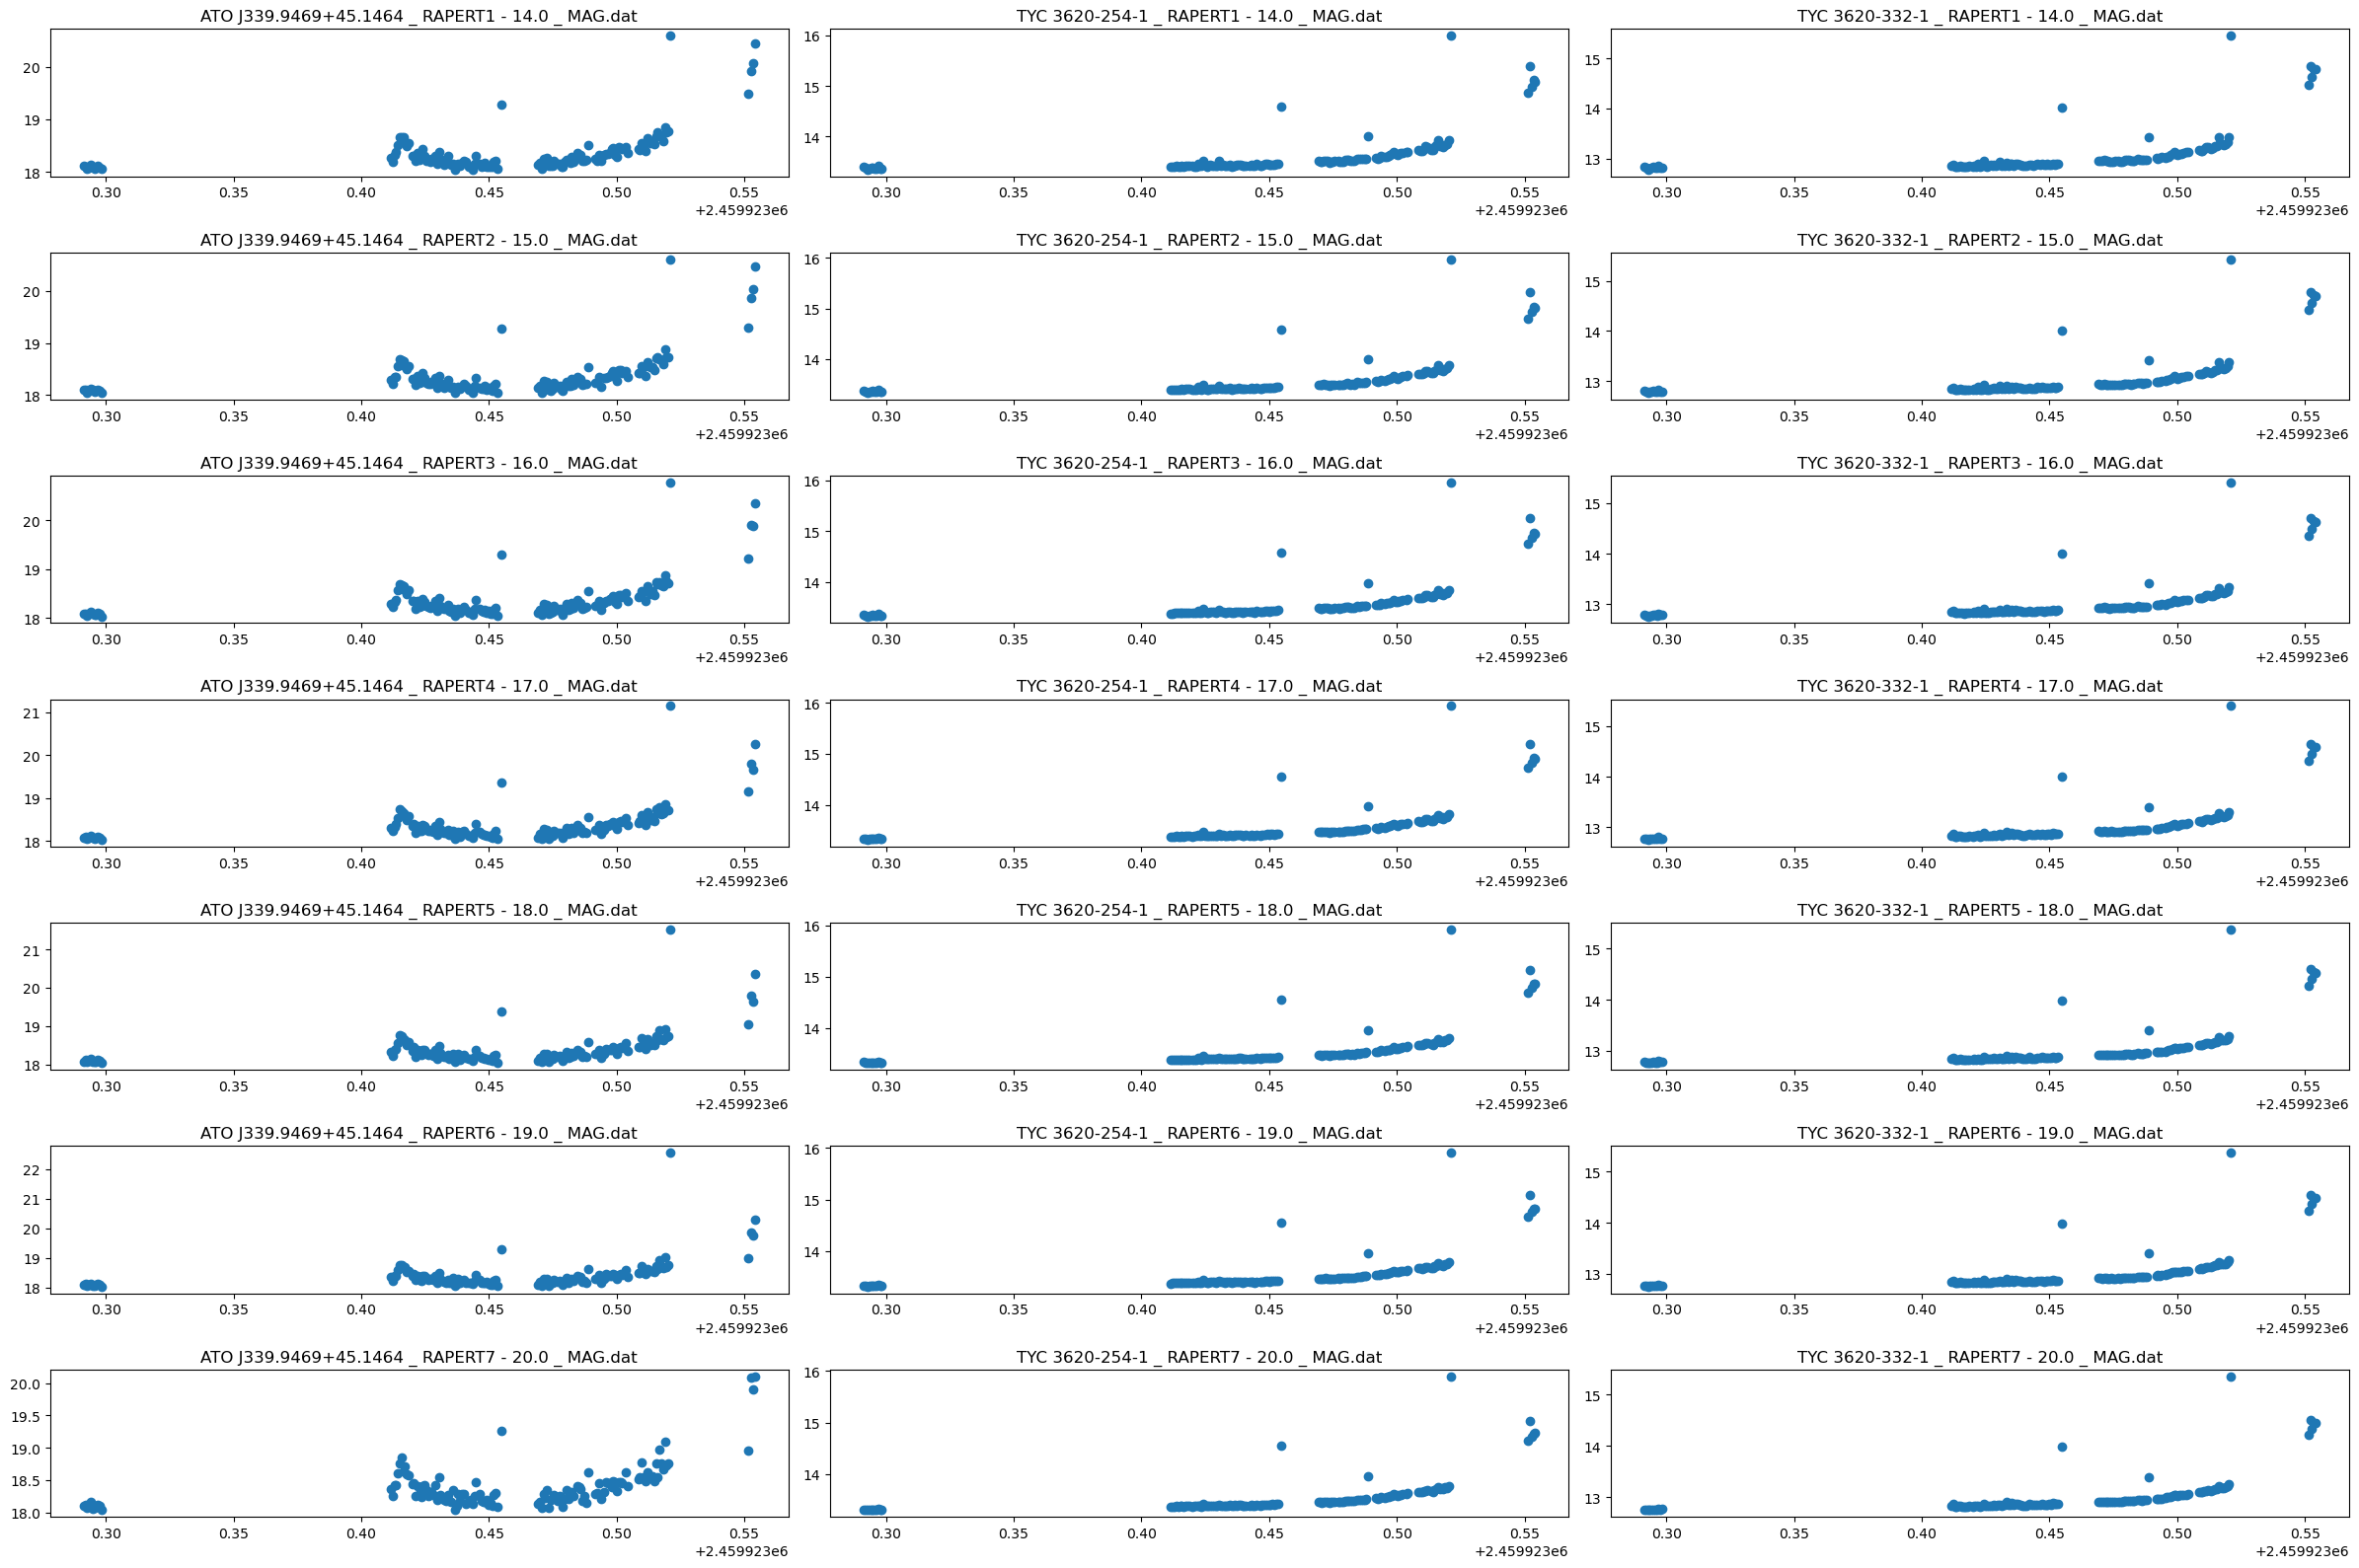

In [26]:
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,20)

FILE = "MAG.dat"
COL =  "MAG"
OBJ_NAMES = ["ATO J339.9469+45.1464", "TYC 3620-254-1","TYC 3620-332-1"]

qphotResultsDir = os.path.join(DATE_DATA_DIR, "qphot-results")

numApertures = len(os.listdir(os.path.join(qphotResultsDir, OBJ_NAMES[0])))
figure, axs = plt.subplots(nrows=numApertures, ncols=len(OBJ_NAMES), figsize=(24, 16))

def plotApertureMags(subplots, objName: str):
	objDir = os.path.join(qphotResultsDir, objName)
	apertureDirs = os.listdir(objDir)
	for i in range(len(subplots)):
		curApertureDir = os.path.join(objDir, apertureDirs[i])
		objData = pd.read_csv(os.path.join(curApertureDir, FILE), sep=' ')
		
		subplots[i].scatter(objData[EPOCH_OBSV_KEY], objData[f'{COL}{i + 1}'])
		subplots[i].set_title(f"{objName} _ {apertureDirs[i]} _ {FILE}")

for i in range(len(OBJ_NAMES)):
	subplots = axs[:, i]
	plotApertureMags(subplots, OBJ_NAMES[i])

figure.tight_layout()
plt.show()